# P08: Monte Carlo methods

In this problem set, we will """"use"""" the matter density of the Universe from Supernovae type Ia data published by the SNLS team ([Conley et al., 2011](http://arxiv.org/abs/1104.1443)). Supernovae of type Ia are standard candles, meaning that their intrinsic luminosity is always roughly the same. The following plot shows all supernova magnitudes contained in the SNLS catalog as a function of redshift.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('scripts')

In [2]:
from SNLSLikelihoodModule import SNLSLikelihoodModule

In [3]:
likelihood = SNLSLikelihoodModule('data/')

Text(0.5, 1.0, 'SNLS dataset')

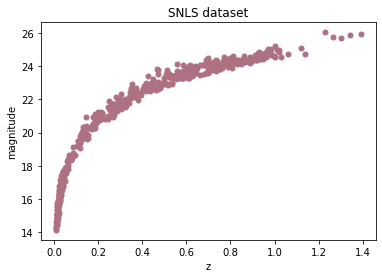

In [4]:
plt.plot(likelihood.lcdparams['zcmb'], likelihood.lcdparams['mb'], marker='.', linewidth=2, markersize=10, \
            linestyle='None', color='#AE7182')
plt.xlabel('z')
plt.ylabel('magnitude')
plt.title('SNLS dataset')

The observed flux $F$ of a given source as a function of redshift $z$ and intrinsic luminosity $L$ is given by $$F(z, L) = \frac L {4\pi d_L(z)^2},$$

where $d_L(z)$ is the luminosity distance to a redshift $z$ which depends on the background cosmology of our Universe. By measuring the luminosity of Supernovae as a function of redshift one can therefore learn about the expansion history of our Universe. 

Below you can see the luminosity distance for a $\Lambda$ CDM universe with a matter density today of $\Omega_m = 0.3$:

[]

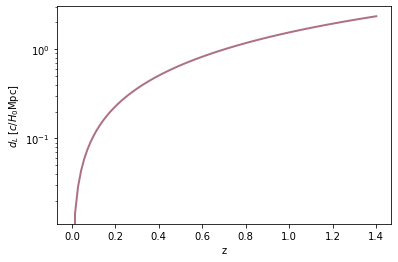

In [5]:
z = np.linspace(0, 1.4, 100)
dL = likelihood.getLCDMLuminosityDistance(z, 0.3)
plt.plot(z, dL, linewidth=2, color='#AE7182')
plt.xlabel('z')
plt.ylabel('$d_L\; [c/H_0 \mathrm{Mpc}]$')
plt.semilogy()

## Problem 1: The SNLS likelihood

In the repository you can find a simplified implementation of the likelihood of the SNLS dataset. 

SNe Ia are not perfect standard candles, and thus the theoretical model for the observed magnitude of a SNe Ia at redshift $z$ is given by $$m_{\mathrm{mod}}=5\log{d_L(z, \Omega_m)} - \alpha(s-1)+\beta C+M,$$
where $d_L(z, \Omega_m)$ is the luminosity distance as before, $s$ is the stretch of the SNe Ia, and $C$ its color. 

The model depends on four parameters: The matter density in the Universe today $\Omega_m$, a stretch parameter $\alpha$, a color parameter $\beta$, and an absolute magnitude parameter $M$. While the first one is a parameter of cosmological interest, the other three parameters are so-called nuisance parameters. 

The likelihood of the data given this model is then given by $$p(\Omega_m, \alpha,\beta, M)\propto e^{-1/2(m_B-m_{\mathrm{mod}})^TC^{-1}(m_B-m_{\mathrm{mod}})},$$ where $m_B$ is the observed SNe Ia magnitude and $C$ the combined covariance matrix. This is implemented in the likelihood script.

Using the SNLS likelihood, find out how to plot the model magnitudes along with the SNLS data and errorbars on the SNLS data given the parameters $\Omega_m = 0.3$, $\alpha = 1.0, \beta = 2.0$, and $M = 24$.

## Solution 1

In [6]:
%matplotlib inline

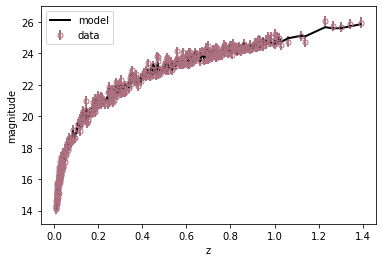

In [7]:
plt.figure()

sigma = np.sqrt(likelihood.getVariance(0,2))

plt.errorbar(likelihood.lcdparams['zcmb'], likelihood.lcdparams['mb'], yerr =  sigma,  marker='.', linewidth=2, markersize=10, \
            linestyle='None', color='#AE7182', label = 'data', mfc = 'none')

# z = np.linspace(0, 1.4, 100)
dL = likelihood.getLCDMLuminosityDistance(z, 0.3)
model_mag = likelihood.getModelMag(0.3, 1.0,2.0, 24)

plt.plot(likelihood.lcdparams['zcmb'], model_mag, linewidth=2, color='k', label = 'model')

plt.xlabel('z')
plt.ylabel('magnitude')
plt.legend()
# plt.title('SNLS dataset')

## Problem 2: Metropolis-Hastings 

(i) Write a Metropolis-Hastings sampler that takes an instance of the likelihood module, an initial position in parameter space, a covariance matrix for a Gaussian proposal distribution, and the number of iterations as an argument and returns the sample from the posterior assuming a flat prior on all parameters. -- flat prior = random initial parameter

(ii) Test it with the following minimal likelihood module for a 1D standard normal distribution.

In [8]:
class standardnormal(object):
    
    def __init__(self):
        pass
    
    def getLogLikelihood(self, x):
        return -.5 * x**2

The standardnormal function has a syntax that makes it similar to problem 3 to get likelihood

## Solution 2

### (i)

In [9]:
def MHsampler(loglike, init, cov, n):
    """
    Metropolis Hastings sampler.
    Args:
    loglike (:class: ): likelihood module with function getLogLikelihood
    init (:obj:`integer`, `float` or `array`): initial position of the chain
    cov (:obj:`integer` or `float` or `array`): covariance matrix of the proposal
    n (:obj:`integer`): number of iterations
    
    Returns:
        chain (:obj:`integer`, `float` or `array`): sampled mcmc parameter values
        likes (:obj:`integer`, `float` or `array`): likelihood values of mcmc
    """
    try:
        d = len(init)
    except:
        d = 1
    chain = np.zeros((n, d))
    likes = np.zeros(n)
    p = init
    ll = loglike.getLogLikelihood(p)
    for i in range(n):
        if d > 1:
            pn = np.random.multivariate_normal(p, cov) #proposal
        else:
            pn = np.random.normal(p, cov)        
        lln = loglike.getLogLikelihood(pn)
        r = np.random.rand()
        if lln-ll > np.log(r):
            p = pn
            ll = lln
        chain[i] = p
        likes[i] = ll

    return chain, likes

### (ii)

In [10]:
like = standardnormal()

In [11]:
# intial position chosen randomly around 0
init = 5 #np.array([0, 12])
# proposal variance chosen as 1
cov = 1 #np.array([[0.01, 0], [0,0.13]])
# run sampler
chain, likes = MHsampler(like, init, cov, 1000)

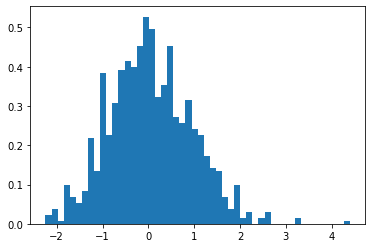

In [12]:
plt.figure()
plt.hist(chain, density = True, bins = 50)
x = np.arange(-4, 3, 0.1)
y = np.random.normal(0,1)
# plt.plot(x,y, c ='r')
plt.show()

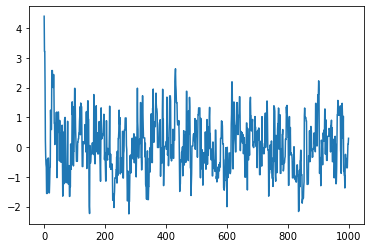

In [13]:
plt.figure()
plt.plot(chain)
plt.show()

## Problem 3: Estimate the parameters $\Omega_m, \alpha, \beta, M$ using the SNLS data

(i) Use your sampler from problem 2 to create a chain of samples from the posterior of the SNLS likelihood assuming a flat prior on all model parameters. As initial points you can choose to start around the parameter values given in problem 1. Additionally, you can use a Gaussian proposal distribution as before and for the start you can assume a standard deviation of $\sigma=0.1$ for all model parameters and set all correlations to zero.

(ii) Write a routine that estimates the fraction of accepted iterations relative to the total number of iterations. 

(iii) Use the created samples to improve your best guess for the covariance matrix of the proposal and monitor the improvement using the acceptance fraction. 

(iv) Once you have acceptance fraction of order $0.1$ or higher, estimate mean, standard deviation, covariance between parameters, and median of the parameters from the chain.

## Solution 3

In [14]:
def MHsampler(loglike, init, cov, n):
    """
    Metropolis Hastings sampler.
    Args:
    loglike (:class: ): likelihood module with function getLogLikelihood
    init (:obj:`integer`, `float` or `array`): initial position of the chain
    cov (:obj:`integer` or `float` or `array`): covariance matrix of the proposal
    n (:obj:`integer`): number of iterations
    
    Returns:
        chain (:obj:`integer`, `float` or `array`): sampled mcmc parameter values
        likes (:obj:`integer`, `float` or `array`): likelihood values of mcmc
    """
    try:
        d = len(init)
    except:
        d = 1
    chain = np.zeros((n, d))
    likes = np.zeros(n)
    p = init
    ll = loglike.getLogLikelihood(*p)
    counter = 0
    for i in range(n):
        if d > 1:
            pn = np.random.multivariate_normal(p, cov)
        else:
            pn = np.random.normal(p, cov)        
        lln = loglike.getLogLikelihood(*pn)
        r = np.random.rand()
        if lln-ll > np.log(r):
            p = pn
            ll = lln
            counter += 1
        chain[i] = p
        likes[i] = ll
        
    return chain, likes, counter/n

This sampler takes care of both 1d and multivariate distributions

In [15]:
def MHsampler(loglike, init, cov, n):
    """
    Metropolis Hastings sampler.
    Args:
    loglike (:class: ): likelihood module with function getLogLikelihood
    init (:obj:`integer`, `float` or `array`): initial position of the chain
    cov (:obj:`integer` or `float` or `array`): covariance matrix of the proposal
    n (:obj:`integer`): number of iterations
    
    Returns:
        chain (:obj:`integer`, `float` or `array`): sampled mcmc parameter values
        likes (:obj:`integer`, `float` or `array`): likelihood values of mcmc
    """
    try:
        d = len(init)
    except:
        d = 1
    chain = np.zeros((n, d))
    likes = np.zeros(n)
    p = init
    if d > 1:
        ll = loglike.getLogLikelihood(*p)
    else:
        ll = loglike.getLogLikelihood(p)
    
    counter = 0
    for i in range(n):
        if d > 1:
            pn = np.random.multivariate_normal(p, cov)
            lln = loglike.getLogLikelihood(*pn)
        else:
            pn = np.random.normal(p, cov)        
            lln = loglike.getLogLikelihood(pn)
        r = np.random.rand()
        if lln-ll > np.log(r):
            p = pn
            ll = lln
            counter += 1
        chain[i] = p
        likes[i] = ll
        
    return chain, likes, counter/n

In [16]:
from SNLSLikelihoodModule import SNLSLikelihoodModule

In [17]:
like = SNLSLikelihoodModule('data/')

In [18]:
# intial position chosen randomly around 0
init = np.array([0.3, 1,2,24])
# proposal variance chosen as 1
cov = np.array([[0.01, 0,0,0], [0,0.1,0,0],[0,0,0.1,0],[0,0,0,0.1]])
# run sampler
chain, likes, acceptance = MHsampler(like, init, cov, 5000)

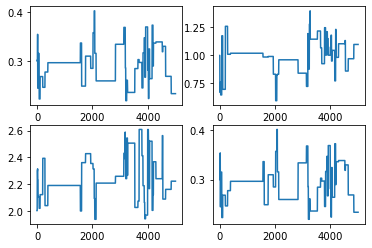

In [19]:
plt.figure()
plt.subplot(221)
plt.plot(chain[:,0])
plt.subplot(222)
plt.plot(chain[:,1])
plt.subplot(223)
plt.plot(chain[:,2])
plt.subplot(224)
plt.plot(chain[:,0])

(ii)

In [20]:
acceptance

0.009

The acceptance fraction is low because the covariance is random, and we include the even the burn-in part of the chain

(iii)

In [21]:
new_cov = np.cov(chain.T) #we take the covariance matrix of all the possible values of the parameters to give show how each parameter varies with respect to one another.

In [22]:
# intial position chosen randomly around 0
init = np.array([0.3, 1,2,24])
# proposal variance chosen as 1
cov = new_cov
# run sampler
chain, likes, acceptance = MHsampler(like, init, cov, 5000)

In [23]:
acceptance

0.3946

We get a better acceptance rate as we use the covariance of the posterior for the new proposal distribution.

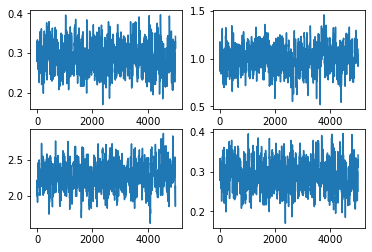

In [24]:
plt.figure()
plt.subplot(221)
plt.plot(chain[:,0])
plt.subplot(222)
plt.plot(chain[:,1])
plt.subplot(223)
plt.plot(chain[:,2])
plt.subplot(224)
plt.plot(chain[:,0])

(iv)

In [25]:
chain_mean = np.mean(chain, axis = 0)
chain_median = np.median(chain, axis = 0)
new_cov_2 = np.cov(chain.T)

In [26]:
chain_mean

array([ 0.28893793,  0.99631474,  2.2771371 , 24.00795345])

In [27]:
chain_median

array([ 0.28793185,  0.99523047,  2.27815612, 24.00818594])

In [28]:
new_cov_2

array([[ 0.00127683, -0.00107352, -0.0013868 ,  0.00080002],
       [-0.00107352,  0.01679178,  0.00197709, -0.00052184],
       [-0.0013868 ,  0.00197709,  0.03009385, -0.00111799],
       [ 0.00080002, -0.00052184, -0.00111799,  0.00070404]])